In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version:",tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

tf version: 2.9.0


In [21]:
dfss = pd.read_parquet(r"D:\RND\Machine_Learning\Datasets/clean_dataset_ml_100_id.parquet")
dfss.fillna(0,inplace=True)
df = dfss.copy()
df['creation_time'] = pd.to_datetime(df['creation_time'])
df.set_index(['creation_time'],drop= True, inplace= True)
df["min"] = df.index.minute
df.sort_index(inplace=True)
df.reset_index(drop=True,inplace=True)
df

,temperature_2m,relative_humidity_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,consumed_unit,lag1,lag2,lag3,lag4,lag5,day,hour,month,dayofweek,dayofyear,label_sensor_id,min
0,12.1,95,10.8,11.4,21.6,0.00,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,0,15
1,8.4,93,6.0,11.9,22.7,6.48,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,72,15
2,8.5,92,5.5,15.6,28.3,0.50,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,71,15
3,12.1,95,10.9,11.4,21.6,0.00,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,4,15
4,8.4,92,5.7,13.6,25.7,0.10,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,70,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461121,18.5,37,14.4,17.7,31.1,0.50,0.5,0.50,14.0,11.00,0.0,25,23,2,6,56,38,0
461122,18.0,35,13.9,16.7,29.1,3.06,2.0,3.06,1.0,3.00,2.0,25,23,2,6,56,37,0
461123,16.9,33,12.8,14.1,25.3,2.00,2.0,2.00,2.0,8.97,2.0,25,23,2,6,56,36,0
461124,18.0,43,14.9,13.5,25.5,0.00,0.0,0.00,0.0,0.00,0.0,25,23,2,6,56,60,0


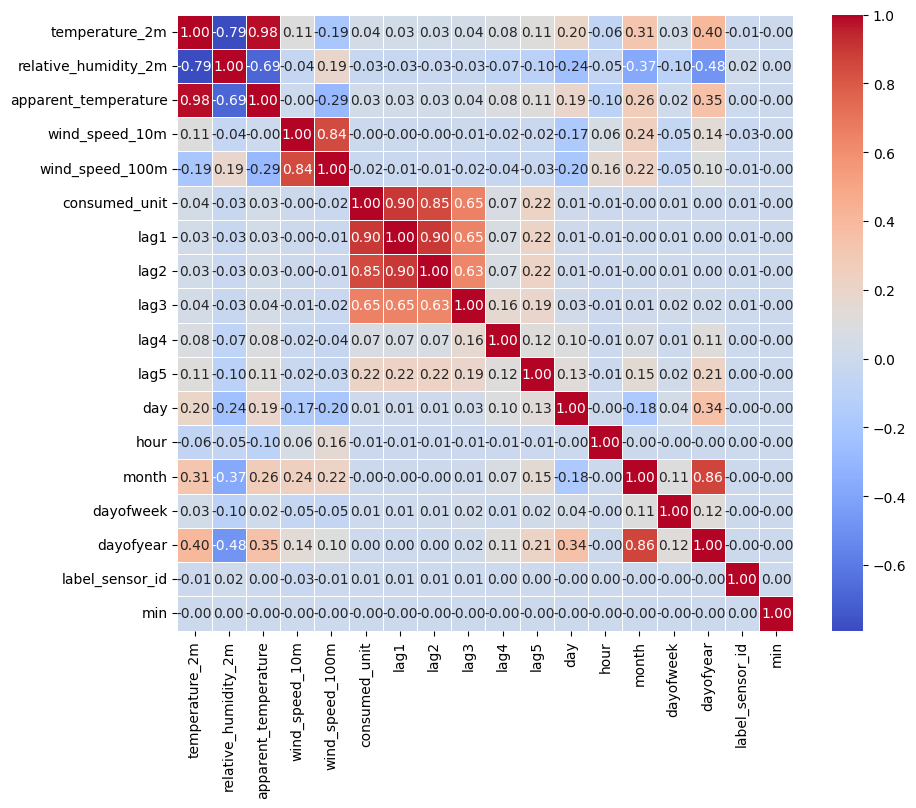

In [23]:
correlation_matrix = df.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
# Show the plot
plt.show()

In [24]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
print("train_df:",len(train_df),"val_df",len(val_df),"test_df:",len(test_df))
# num_features = df.shape[1]
train_features = train_df.copy()
val_features = val_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('consumed_unit')
val_labels = val_features.pop('consumed_unit')
test_labels = test_features.pop('consumed_unit')

train_df: 322788 val_df 92225 test_df: 46113


In [25]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [26]:
# df.describe().transpose()
train_features.describe()[1:3]

,temperature_2m,relative_humidity_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,lag1,lag2,lag3,lag4,lag5,day,hour,month,dayofweek,dayofyear,label_sensor_id,min
mean,16.028612,56.198781,13.686860,10.290744,16.377111,2.136881,2.136412,2.083054,1.773431,1.320439,13.631647,11.473686,1.207381,2.850118,20.060448,51.069389,22.498792
std,5.322424,21.618724,5.547266,3.895863,7.221692,3.851971,3.851689,3.820286,3.623865,3.222156,9.275315,6.933700,0.405431,1.979076,11.285161,29.392028,16.768125


In [25]:
# first = np.array(train_features[:1])
# with np.printoptions(precision=2, suppress=True):
#     print('First example:', first)
#     print('Normalized:', normalizer(first).numpy())

In [28]:
test_results={}

In [67]:
def compile_and_fit(model,
                    train_features = train_features,
                    train_labels = train_labels, 
                    patience=5,
                    batch_size = None,
                    MAX_EPOCHS = 30):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train_features,train_labels, epochs=MAX_EPOCHS,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=1,
                        )
    return history


In [68]:
# linear_model = tf.keras.Sequential([
#     normalizer,
#     layers.Dense(64, activation='relu',input_shape=(17,)),
#     layers.Dense(units=1)
# ])
# linear_model.compile(optimizer='adam', loss='mean_squared_error')

model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu',input_shape=(17,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)])

history = compile_and_fit(model,train_features,train_labels,batch_size= 16)

Epoch 1/30
8070/8070 [==============================] - 10s 1ms/step - loss: 3.0775 - mean_absolute_error: 0.7523 - val_loss: 2.0041 - val_mean_absolute_error: 0.6398
Epoch 2/30
8070/8070 [==============================] - 9s 1ms/step - loss: 2.8403 - mean_absolute_error: 0.7027 - val_loss: 2.1702 - val_mean_absolute_error: 0.6913
Epoch 3/30
8070/8070 [==============================] - 9s 1ms/step - loss: 2.7647 - mean_absolute_error: 0.6860 - val_loss: 1.8848 - val_mean_absolute_error: 0.6361
Epoch 4/30
8070/8070 [==============================] - 9s 1ms/step - loss: 2.7232 - mean_absolute_error: 0.6774 - val_loss: 1.8251 - val_mean_absolute_error: 0.6029
Epoch 5/30
8070/8070 [==============================] - 10s 1ms/step - loss: 2.6999 - mean_absolute_error: 0.6726 - val_loss: 2.2948 - val_mean_absolute_error: 0.7983
Epoch 6/30
8070/8070 [==============================] - 20s 2ms/step - loss: 2.6800 - mean_absolute_error: 0.6690 - val_loss: 1.8103 - val_mean_absolute_error: 0.6499
E

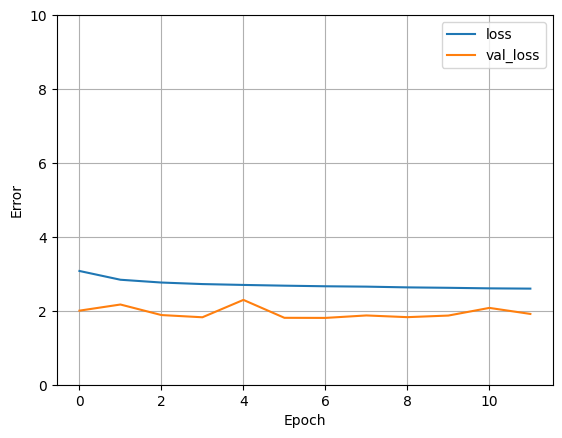

In [69]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
  
plot_loss(history)

In [70]:
def training_score(history):
    print(f"training_score:loss:{history.history['loss'][-1]:.3f},mae:{history.history['mean_absolute_error'][-1]:.3f}")

In [71]:
def evaluate(model,test_features= test_features,test_labels= test_labels):
    score = model.evaluate(val_features,val_labels,verbose=0)
    print("val_score:",score)
    return score
training_score(history)
score = evaluate(model)    

training_score:loss:2.600,mae:0.654
val_score: [2.3535990715026855, 0.7162377238273621]


In [74]:
def prediction(model, input_data,input_labels=None,verbose=1):
    y_pred = model.predict(input_data,verbose)
    # plt.plot(y_pred)
    # plt.plot(np.array(input_labels))
    # plt.show()
    # Calculate MAE, MSE, and R²
    mae = mean_absolute_error(input_labels, y_pred)
    mse = mean_squared_error(input_labels, y_pred)
    r2 = r2_score(input_labels, y_pred)
    print(f"mae: {mae:.3f}")
    print(f"mse: {mse:.3f}")
    print(f"R2: {r2:.3f}")
    return y_pred

predicted_value = prediction(model,input_data=test_features,input_labels=test_labels)

46113/46113 [==============================] - 27s 585us/step
mae: 0.802
mse: 3.319
R2: 0.786


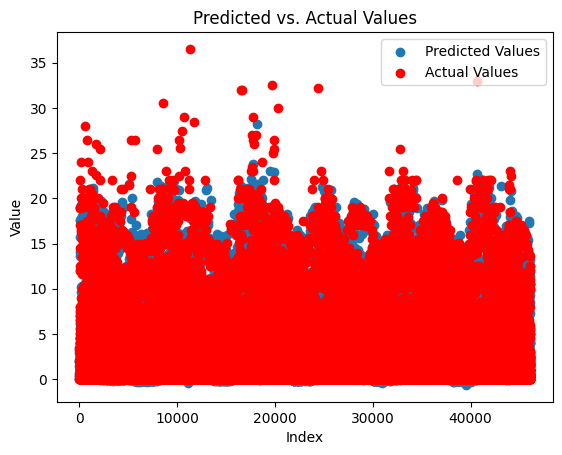

In [75]:
# import matplotlib.pyplot as plt

# Assuming predicted_value is a list or array of predicted values
# Generate an array of indices for the x-axis
x = np.arange(len(predicted_value))
# start = 40
# values = 40
# x = np.arange(values)


# Create a scatter plot
plt.scatter(x, predicted_value, label='Predicted Values')

# If you want to also plot the actual test labels for comparison
plt.scatter(x, test_labels, label='Actual Values', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs. Actual Values')
plt.legend()

# Show the plot
plt.show()


In [76]:
first_dense_layer = model.layers[1]  
weights, biases = first_dense_layer.get_weights()
print("Weights shape:", weights.shape)
feature_importance = np.abs(weights).mean(axis=1)
for i, importance in enumerate(feature_importance):
    print(f"Feature {train_features.columns[i]}: Importance {importance}")

Weights shape: (17, 64)
Feature temperature_2m: Importance 0.1644020676612854
Feature relative_humidity_2m: Importance 0.19078963994979858
Feature apparent_temperature: Importance 0.191731795668602
Feature wind_speed_10m: Importance 0.1388258934020996
Feature wind_speed_100m: Importance 0.16852763295173645
Feature lag1: Importance 0.47867101430892944
Feature lag2: Importance 0.3617398142814636
Feature lag3: Importance 0.3167746961116791
Feature lag4: Importance 0.17375493049621582
Feature lag5: Importance 0.17655107378959656
Feature day: Importance 0.20002540946006775
Feature hour: Importance 0.23848497867584229
Feature month: Importance 0.3121654987335205
Feature dayofweek: Importance 0.20959189534187317
Feature dayofyear: Importance 0.21254530549049377
Feature label_sensor_id: Importance 0.17309918999671936
Feature min: Importance 0.22693054378032684


In [77]:
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)
result = permutation_importance(model, test_features, test_labels, 
                                n_repeats=10, random_state=42, 
                                scoring=custom_scorer)
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]:
    print(f"Feature {train_features.columns[i]}: Importance {result.importances_mean[i]:.8f}")

1442/1442 [==============================] - 1s 628us/step
Feature lag1: Importance 1.86740035
Feature lag2: Importance 0.05481076
Feature lag3: Importance 0.04969077
Feature lag4: Importance 0.00608187
Feature apparent_temperature: Importance 0.00570368
Feature wind_speed_100m: Importance 0.00289086
Feature temperature_2m: Importance 0.00246233
Feature hour: Importance 0.00216630
Feature wind_speed_10m: Importance 0.00213428
Feature dayofweek: Importance 0.00105774
Feature lag5: Importance 0.00069142
Feature min: Importance 0.00055701
Feature dayofyear: Importance 0.00038540
Feature day: Importance 0.00013813
Feature relative_humidity_2m: Importance 0.00005697
Feature month: Importance 0.00000000
Feature label_sensor_id: Importance -0.00039405


In [72]:
test_results['linear_model'] = model.evaluate(
    test_features, test_labels, verbose=0)

In [73]:
test_results

{'linear_model': [2.5509064197540283, 0.6465504169464111]}

In [44]:

model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu',input_shape=(17,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)])

model.compile(loss='mean_absolute_error',
      # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
      optimizer=tf.keras.optimizers.Adam(0.001),
      metrics=['mean_squared_error',])


## with SGD

In [43]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.6082 - mean_squared_error: 3.2249 - mean_absolute_percentage_error: 122466136.0000 - val_loss: 0.6039 - val_mean_squared_error: 2.4309 - val_mean_absolute_percentage_error: 72799728.0000
Epoch 2/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5728 - mean_squared_error: 3.0927 - mean_absolute_percentage_error: 108785408.0000 - val_loss: 0.4927 - val_mean_squared_error: 2.1764 - val_mean_absolute_percentage_error: 86439752.0000
Epoch 3/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5559 - mean_squared_error: 3.0275 - mean_absolute_percentage_error: 103650776.0000 - val_loss: 0.5009 - val_mean_squared_error: 2.2909 - val_mean_absolute_percentage_error: 93149344.0000
Epoch 4/10
4513/4513 [==============================] - 21s 5ms/step - loss: 0.5513 - mean_squared_error: 2.9900 - mean_absolute_percentage_error: 103141232.0000 - val_loss: 0.4925 - val_mean_squared_er

### with adam

In [45]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5977 - mean_squared_error: 3.1802 - val_loss: 0.5138 - val_mean_squared_error: 2.2968
Epoch 2/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5487 - mean_squared_error: 3.0303 - val_loss: 0.5098 - val_mean_squared_error: 2.2528
Epoch 3/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5362 - mean_squared_error: 2.9998 - val_loss: 0.4855 - val_mean_squared_error: 2.2707
Epoch 4/10
4513/4513 [==============================] - 10s 2ms/step - loss: 0.5261 - mean_squared_error: 2.9381 - val_loss: 0.4865 - val_mean_squared_error: 2.2423
Epoch 5/10
4513/4513 [==============================] - 11s 3ms/step - loss: 0.5196 - mean_squared_error: 2.8865 - val_loss: 0.4681 - val_mean_squared_error: 2.1978
Epoch 6/10
4513/4513 [==============================] - 12s 3ms/step - loss: 0.5152 - mean_squared_error: 2.8441 - val_loss: 0.4676 - val_mean_squared_error: 2.1715
Epoch 7/10

In [46]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense_20 (Dense)            (None, 64)                1152      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,412
Trainable params: 5,377
Non-trainable params: 35
_________________________________________________________________
